In [94]:
import numpy as np
import pandas as pd
import nltk
import string
import spacy
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
nltk.download('punkt')
import re

[nltk_data] Downloading package punkt to /Users/jasonyoo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


The goal of this project is to allow users to copy & paste long passages they do not wish to read, and gain understanding of it by simply reading a few sentences this model determines most important. Therefore, the input will constantly change, and be expected to be texts. 

In [10]:
text = input('COPY & PASTE THE TEXTS YOU ARE TOO LAZY TO READ \n \n')
df = pd.DataFrame({'text': text}, index=[0])

COPY & PASTE THE TEXTS YOU ARE TOO LAZY TO READ 
 
When Jonathan Seryak moved into his apartment on New York City’s Upper East Side earlier this year he planned to join the high-end Equinox gym across the street. But as the coronavirus pandemic closed fitness centers and other businesses across the U.S., he set up in his apartment some weights that he has had since high school.  His new regimen of weightlifting in the apartment and running outdoors has Mr. Seryak, 31 years old, reconsidering the gym as well as the boutique spinning and yoga studios he visited with friends.  “I’m never going to sign up for a full brick-and-mortar gym with a monthly charge anymore,” says Mr. Seryak, who likes the low cost and convenience of his new workout. “I don’t need to coordinate, text somebody and say we’re gonna pay for this class—it’s just insanely easy.”  The pandemic has accelerated a shift away from physical gyms and toward at-home virtual fitness programs, which now go far beyond what Jane Fo

For developingi this model I have copied and pasted an article from Wall street journal. 

In [19]:
def text_cleaner(text):
    text = re.sub(r'--', ' ', text)
    text = re.sub("[\[].&*?\:;/,()|", '', text)
    text = re.sub(r'(\b|\s+\-?|^\-?)(\d_|\d*\.\d+)\b', '', text)
    text = ' '.join(text.split())
    text = re.sub('[1234567890]', '', text)
    return text

In [23]:
text_cleaned = text_cleaner(text)

In [28]:
nlp = spacy.load('en')
nlp.max_length = 100000
text_doc = nlp(text_cleaned)

In [29]:
def word_frequencies(text):
    words = []
    for token in text:
        if not token.is_punct:
            words.append(token.text)
    return Counter(words)

word_freq = word_frequencies(text_doc).most_common(20)
print(word_freq)

[('the', 34), ('to', 33), ('and', 31), ('a', 23), ('of', 17), ('in', 16), ('for', 16), ('on', 11), ('as', 10), ('classes', 10), ('is', 9), ('’s', 8), ('with', 8), ('it', 8), ('gym', 7), ('fitness', 7), ('that', 7), ('has', 7), ('studios', 7), ('I', 7)]


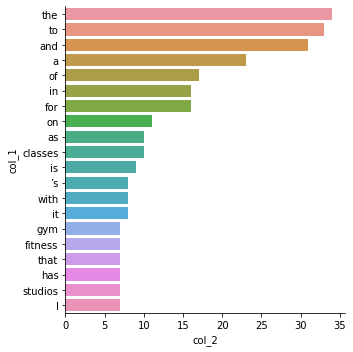

In [105]:
freq_list = {}
col_1 = []
col_2 = []
for i in range(len(word_freq)):
    col_1.append(word_freq[i][0])
    col_2.append(word_freq[i][1])
freq_list = {'col_1': col_1, 'col_2': col_2}

freq_list = pd.DataFrame.from_dict(freq_list)

sns.catplot(x = 'col_2', y='col_1', kind='bar', data=freq_list)

As new passages are inputed, 20 most frequently repeated words will be visualized here.

In [108]:
from wordcloud import WordCloud, STOPWORDS

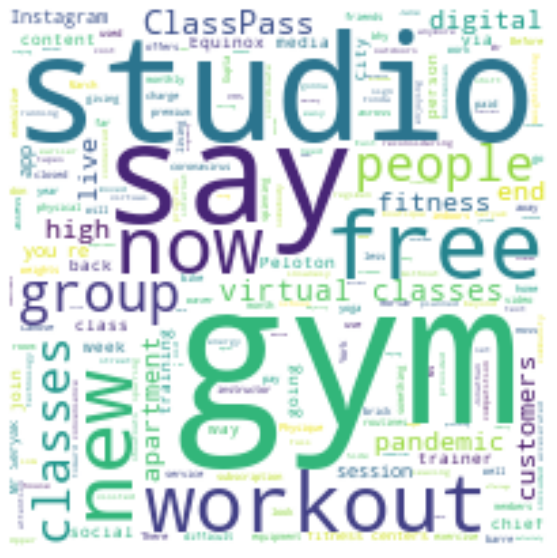

In [125]:
wordcloud = WordCloud(width=200, height=200, background_color='white',
                          min_font_size=2).generate(text_cleaned)

plt.figure(figsize=[20, 10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

wordcloud visualization of the text

In [6]:
from nltk.tokenize import sent_tokenize

In [7]:
sentences = []
for i in df['text']:
    sentences.append(sent_tokenize(i))

sentences = [y for x in sentences for y in x]

In [9]:
sentences[:5]

['When Jonathan Seryak moved into his apartment on New York City’s Upper East Side earlier this year he planned to join the high-end Equinox gym across the street.',
 'But as the coronavirus pandemic closed fitness centers and other businesses across the U.S., he set up in his apartment some weights that he has had since high school.',
 'His new regimen of weightlifting in the apartment and running outdoors has Mr. Seryak, 31 years old, reconsidering the gym as well as the boutique spinning and yoga studios he visited with friends.',
 '“I’m never going to sign up for a full brick-and-mortar gym with a monthly charge anymore,” says Mr. Seryak, who likes the low cost and convenience of his new workout.',
 '“I don’t need to coordinate, text somebody and say we’re gonna pay for this class—it’s just insanely easy.”  The pandemic has accelerated a shift away from physical gyms and toward at-home virtual fitness programs, which now go far beyond what Jane Fonda VHS tapes once provided.']

Breaking the text into individual sentences using sent_tokenize() function

In [92]:
#!unzip glove*.zip

In [93]:
word_embeddings = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = coefs
f.close()

Using GloVe to create vectors for the input sentences. Although Bag-of-Words and TF-IDF can also be used to create features for the sentences, but these methods ignore the order of the words. 

In [94]:
#len(word_embeddings)

In [95]:
clean_sentences = pd.Series(sentences).str.replace("[^a-zA-Z]", " ")
clean_sentences = [s.lower() for s in clean_sentences]

In [96]:
#nltk.download('stopwords')

In [97]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [98]:
def remove_stopwords(sen):
    sen_new = " ".join([i for i in sen if i not in stop_words])
    return sen_new

In [99]:
clean_sentences = [remove_stopwords(r.split()) for r in clean_sentences]

I have removed stopwords, punctuations, numbers, and special characters, and made the texts lower cases

In [100]:
sentence_vectors = []
for i in clean_sentences:
    if len(i) != 0:
        v = sum([word_embeddings.get(w, np.zeros((100,))) for w in i.split()])/(len(i.split())+0.001)
    else:
        v = np.zeros((100,))
    sentence_vectors.append(v)

In [101]:
sim_mat = np.zeros([len(sentences), len(sentences)])

First, defining a zero matrix of dimensions, and then I will initialize this matrix with cosine similarity scores of the sentences. 

In [102]:
from sklearn.metrics.pairwise import cosine_similarity

In [103]:
for i in range(len(sentences)):
    for j in range(len(sentences)):
        if i != j:
            sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,100), sentence_vectors[j].reshape(1,100))[0,0]

In [104]:
import networkx as nx

nx_graph = nx.from_numpy_array(sim_mat)
scores = nx.pagerank(nx_graph)

In [105]:
ranked_sentences = sorted(((scores[i], s) for i,s in enumerate(sentences)), reverse=True)

In [107]:
for i in range(5):
    print(ranked_sentences[i][1]+ '\n')

With new technology, internet-connected equipment and apps, people like Mr. Seryak say they are enjoying the attention, energy and community of in-person classes—shoutouts and competition included—without leaving the house.

The group also launched its Variis mobile app in March, giving people who have paid for membership to one of its 99 U.S. gyms—which vary by club but start at roughly $190 a month (plus initiation fee) in New York City—free access to hundreds of virtual classes.

“I don’t need to coordinate, text somebody and say we’re gonna pay for this class—it’s just insanely easy.”  The pandemic has accelerated a shift away from physical gyms and toward at-home virtual fitness programs, which now go far beyond what Jane Fonda VHS tapes once provided.

She has been approached by new customers in recent weeks as people look for ways to exercise safely indoors.

Kaavya Gupta, 28, used to go to the free gym in her San Francisco apartment building almost daily to use a Peloton statio

model extracted top 5 sentences based on their rankings for summary generation. 

I attempted to build a model to reduce the amount of texts from the input script, and extracted the top 5 sentences, which relatively well summarizes the input sentence. Again, this model is intended to be used for different scripts every time it is used. I want users to be able to copy & paste whichever scripts they would like to be condenced. I have tested this model with 10 different scripts, which includes news articles, analyst summaries, notes to shareholders, and so on to examine if the output adequately summarizes the input script, and the evaluation was satisfactory for all test runs. 